# Predict TripAdvisor Rating

# import

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import re
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns 
%matplotlib inline

# Загружаем специальный удобный инструмент для разделения датасета:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
multilabelbinarizer = MultiLabelBinarizer()

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/kaggle/input/sf-dst-restaurant-rating/sample_submission.csv
/kaggle/input/sf-dst-restaurant-rating/main_task.csv
/kaggle/input/sf-dst-restaurant-rating/kaggle_task.csv


In [2]:
# всегда фиксируйте RANDOM_SEED, чтобы ваши эксперименты были воспроизводимы!
RANDOM_SEED = 42

In [3]:
# зафиксируем версию пакетов, чтобы эксперименты были воспроизводимы:
!pip freeze > requirements.txt

# DATA

In [4]:
DATA_DIR = '/kaggle/input/sf-dst-restaurant-rating/'
df_train = pd.read_csv(DATA_DIR+'/main_task.csv')
df_test = pd.read_csv(DATA_DIR+'kaggle_task.csv')
sample_submission = pd.read_csv(DATA_DIR+'/sample_submission.csv')

In [5]:
# ВАЖНО! дря корректной обработки признаков объединяем трейн и тест в один датасет
df_train['sample'] = 1 # помечаем где у нас трейн
df_test['sample'] = 0 # помечаем где у нас тест
df_test['Rating'] = 0 # в тесте у нас нет значения Rating, мы его должны предсказать, по этому пока просто заполняем нулями

data = df_test.append(df_train, sort=False).reset_index(drop=True) # объединяем

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 11 columns):
Restaurant_id        50000 non-null object
City                 50000 non-null object
Cuisine Style        38410 non-null object
Ranking              50000 non-null float64
Price Range          32639 non-null object
Number of Reviews    46800 non-null float64
Reviews              49998 non-null object
URL_TA               50000 non-null object
ID_TA                50000 non-null object
sample               50000 non-null int64
Rating               50000 non-null float64
dtypes: float64(3), int64(1), object(7)
memory usage: 4.2+ MB


Подробнее по признакам:
* City: Город 
* Cuisine Style: Кухня
* Ranking: Ранг ресторана относительно других ресторанов в этом городе
* Price Range: Цены в ресторане в 3 категориях
* Number of Reviews: Количество отзывов
* Reviews: 2 последних отзыва и даты этих отзывов
* URL_TA: страница ресторана на 'www.tripadvisor.com' 
* ID_TA: ID ресторана в TripAdvisor
* Rating: Рейтинг ресторана

In [7]:
data.sample(5)

,Restaurant_id,City,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA,sample,Rating
40808,id_7114,Paris,['Spanish'],7115.0,$$ - $$$,24.0,"[['Must try'], ['01/14/2017']]",/Restaurant_Review-g187147-d11655457-Reviews-C...,d11655457,1,4.0
4772,id_4772,Edinburgh,['Soups'],1305.0,NaN,4.0,"[['Friendly staff, acceptable coffee, good so....",/Restaurant_Review-g186525-d7271995-Reviews-So...,d7271995,0,0.0
21685,id_13191,Paris,NaN,13193.0,NaN,7.0,"[['great views, nice food at reasonable price....",/Restaurant_Review-g187147-d1091107-Reviews-Le...,d1091107,1,3.5
8819,id_8819,Paris,['Chinese'],12046.0,NaN,3.0,"[[], []]",/Restaurant_Review-g187147-d8014994-Reviews-De...,d8014994,0,0.0
2822,id_2822,London,NaN,13370.0,NaN,4.0,"[['A well established place', 'Excellent'], ['...",/Restaurant_Review-g186338-d10525104-Reviews-B...,d10525104,0,0.0


In [8]:
data.Reviews[1]

"[['Very good reviews!', 'Fine dining in Hakaniemi'], ['12/05/2017', '10/29/2017']]"

Как видим, большинство признаков у нас требует очистки и предварительной обработки.

# Cleaning and Prepping Data

## 1. Обработка NAN 
У наличия пропусков могут быть разные причины, но пропуски нужно либо заполнить, либо исключить из набора полностью. Но с пропусками нужно быть внимательным, **даже отсутствие информации может быть важным признаком!**   
По этому перед обработкой NAN лучше вынести информацию о наличии пропуска как отдельный признак 

In [9]:
# Для примера я возьму столбец Number of Reviews
data['Number_of_Reviews_isNAN'] = pd.isna(data['Number of Reviews']).astype('uint8')

In [10]:
data['Number_of_Reviews_isNAN']

0        0
1        0
2        0
3        0
4        0
        ..
49995    0
49996    0
49997    0
49998    0
49999    0
Name: Number_of_Reviews_isNAN, Length: 50000, dtype: uint8

In [11]:
# Далее заполняем пропуски 0, вы можете попробовать заполнением средним или средним по городу и тд...
data['Number of Reviews'].fillna(0, inplace=True)

### 2. Обработка признаков
Для начала посмотрим какие признаки у нас могут быть категориальными.

In [12]:
data.nunique(dropna=False)

Restaurant_id              13094
City                          31
Cuisine Style              10732
Ranking                    12975
Price Range                    4
Number of Reviews           1574
Reviews                    41858
URL_TA                     49963
ID_TA                      49963
sample                         2
Rating                        10
Number_of_Reviews_isNAN        2
dtype: int64

In [13]:
# для One-Hot Encoding в pandas есть готовая функция - get_dummies. Особенно радует параметр dummy_na
data = pd.get_dummies(data, columns=[ 'City',], dummy_na=True)

In [14]:
data.head(5)

,Restaurant_id,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA,sample,Rating,...,City_Oporto,City_Oslo,City_Paris,City_Prague,City_Rome,City_Stockholm,City_Vienna,City_Warsaw,City_Zurich,City_nan
0,id_0,"['Bar', 'Pub']",12963.0,$$ - $$$,4.0,"[[], []]",/Restaurant_Review-g187147-d10746918-Reviews-L...,d10746918,0,0.0,...,0,0,1,0,0,0,0,0,0,0
1,id_1,"['European', 'Scandinavian', 'Gluten Free Opti...",106.0,$$ - $$$,97.0,"[['Very good reviews!', 'Fine dining in Hakani...",/Restaurant_Review-g189934-d6674944-Reviews-Ra...,d6674944,0,0.0,...,0,0,0,0,0,0,0,0,0,0
2,id_2,['Vegetarian Friendly'],810.0,$$ - $$$,28.0,"[['Better than the Links', 'Ivy Black'], ['12/...",/Restaurant_Review-g186525-d13129638-Reviews-B...,d13129638,0,0.0,...,0,0,0,0,0,0,0,0,0,0
3,id_3,"['Italian', 'Mediterranean', 'European', 'Vege...",1669.0,$$$$,202.0,"[['Most exquisite', 'Delicious and authentic']...",/Restaurant_Review-g186338-d680417-Reviews-Qui...,d680417,0,0.0,...,0,0,0,0,0,0,0,0,0,0
4,id_4,"['Italian', 'Mediterranean', 'European', 'Seaf...",37.0,$$$$,162.0,"[['Always the best in bratislava', 'Very good ...",/Restaurant_Review-g274924-d1112354-Reviews-Ma...,d1112354,0,0.0,...,0,0,0,0,0,0,0,0,0,0


In [15]:
data.sample(5)

,Restaurant_id,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA,sample,Rating,...,City_Oporto,City_Oslo,City_Paris,City_Prague,City_Rome,City_Stockholm,City_Vienna,City_Warsaw,City_Zurich,City_nan
4642,id_4642,"['Japanese', 'Asian']",825.0,$$ - $$$,4.0,"[[], []]",/Restaurant_Review-g189180-d13434222-Reviews-T...,d13434222,0,0.0,...,1,0,0,0,0,0,0,0,0,0
11071,id_1504,"['Chinese', 'Asian', 'Mongolian']",1507.0,$,18.0,"[['An average experience', 'Good cheap buffet'...",/Restaurant_Review-g189541-d3494454-Reviews-Re...,d3494454,1,3.5,...,0,0,0,0,0,0,0,0,0,0
25361,id_2116,"['Vegetarian Friendly', 'Gluten Free Options']",2118.0,$$ - $$$,30.0,"[['Good service, good starter but bland main']...",/Restaurant_Review-g187849-d11992839-Reviews-P...,d11992839,1,4.0,...,0,0,0,0,0,0,0,0,0,0
43041,id_156,"['Italian', 'Mediterranean']",157.0,$,1020.0,"[['Real Rome: Pantheon, fountain and Antica S....",/Restaurant_Review-g187791-d1795116-Reviews-An...,d1795116,1,4.5,...,0,0,0,0,1,0,0,0,0,0
23559,id_1834,NaN,1837.0,NaN,9.0,"[['Nice place', 'Potential for (even) more...!...",/Restaurant_Review-g187331-d5819363-Reviews-Li...,d5819363,1,4.0,...,0,0,0,0,0,0,0,0,0,0


#### Возьмем следующий признак "Price Range".

In [16]:
data['Price Range'].value_counts()

$$ - $$$    23041
$            7816
$$$$         1782
Name: Price Range, dtype: int64

По описанию 'Price Range' это - Цены в ресторане.  
Их можно поставить по возрастанию (значит это не категориальный признак). А это значит, что их можно заменить последовательными числами, например 1,2,3  
*Попробуйте сделать обработку этого признака уже самостоятельно!*

In [17]:
#Заменяем доллары на числовые значения
data['Price Range'] = data['Price Range'].apply(lambda x: str(x).replace('$$$$','3'))
data['Price Range'] = data['Price Range'].apply(lambda x: str(x).replace('$$ - $$$','2'))
data['Price Range'] = data['Price Range'].apply(lambda x: str(x).replace('$','1'))

In [18]:
#Заменяем строковые переменные числовыми
data['Price Range'] = data['Price Range'].apply(pd.to_numeric, downcast='integer', errors='coerce')

In [19]:
#Заменяем пропуски медианным значение
data['Price Range'].fillna(data['Price Range'].median(), inplace=True)
data['Price Range'] = data['Price Range'].astype(int)
data['Price Range'].value_counts()

2    40402
1     7816
3     1782
Name: Price Range, dtype: int64

### Посмотрим распределение признака

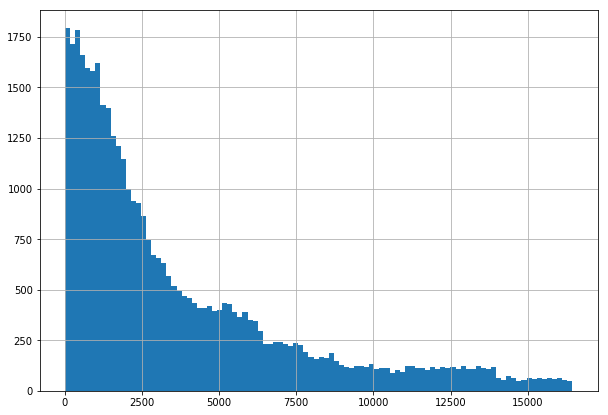

In [20]:
plt.rcParams['figure.figsize'] = (10,7)
df_train['Ranking'].hist(bins=100)

У нас много ресторанов, которые не дотягивают и до 2500 места в своем городе, а что там по городам?

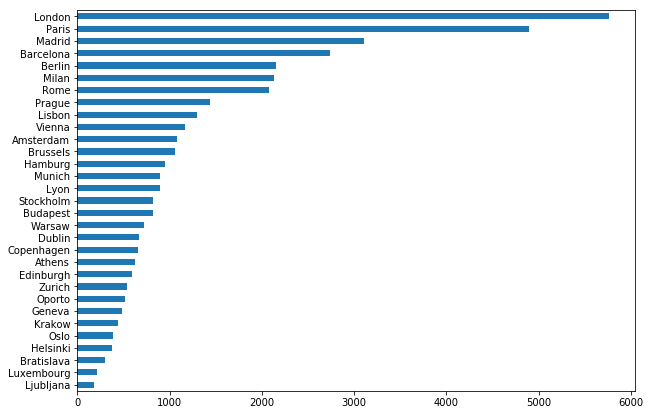

In [21]:
df_train['City'].value_counts(ascending=True).plot(kind='barh')

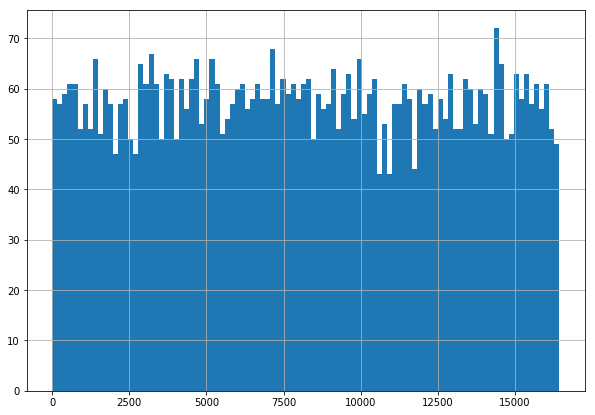

In [22]:
df_train['Ranking'][df_train['City'] =='London'].hist(bins=100)

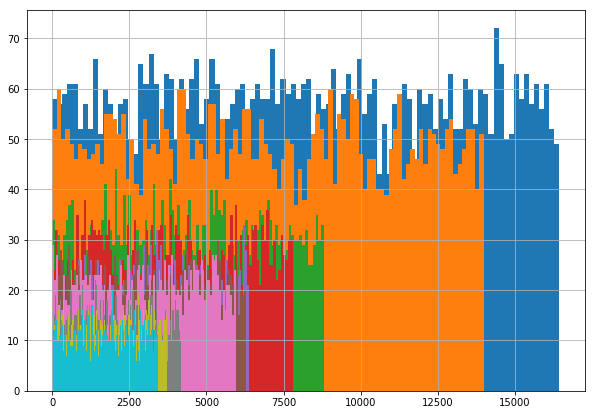

In [23]:
# посмотрим на топ 10 городов
for x in (df_train['City'].value_counts())[0:10].index:
    df_train['Ranking'][df_train['City'] == x].hist(bins=100)
plt.show()

### Посмотрим распределение целевой переменной

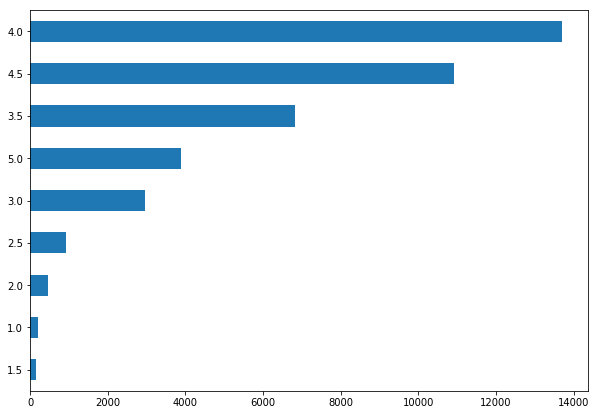

In [24]:
df_train['Rating'].value_counts(ascending=True).plot(kind='barh')

### Посмотрим распределение целевой переменной относительно признака

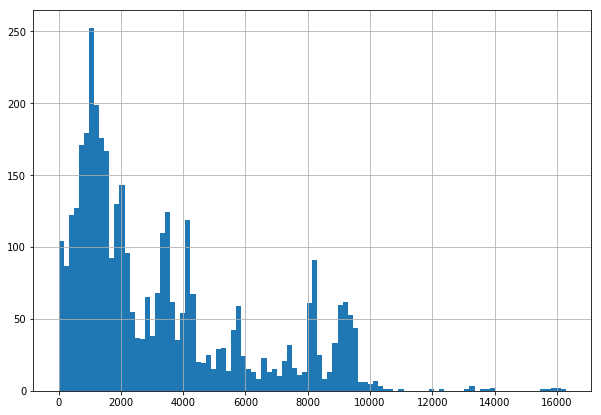

In [25]:
df_train['Ranking'][df_train['Rating'] == 5].hist(bins=100)

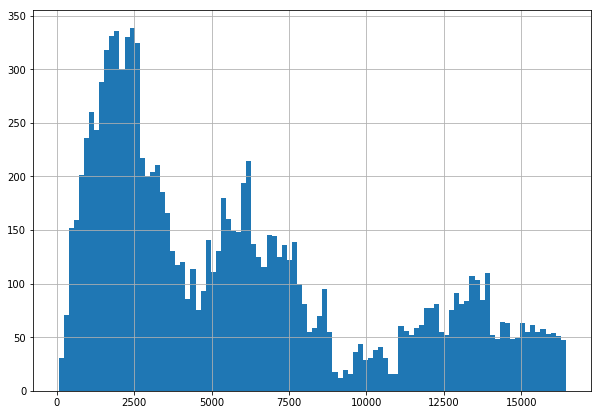

In [26]:
df_train['Ranking'][df_train['Rating'] < 4].hist(bins=100)

### И один из моих любимых - [корреляция признаков](https://ru.wikipedia.org/wiki/Корреляция)
На этом графике уже сейчас вы сможете заметить, как признаки связаны между собой и с целевой переменной.

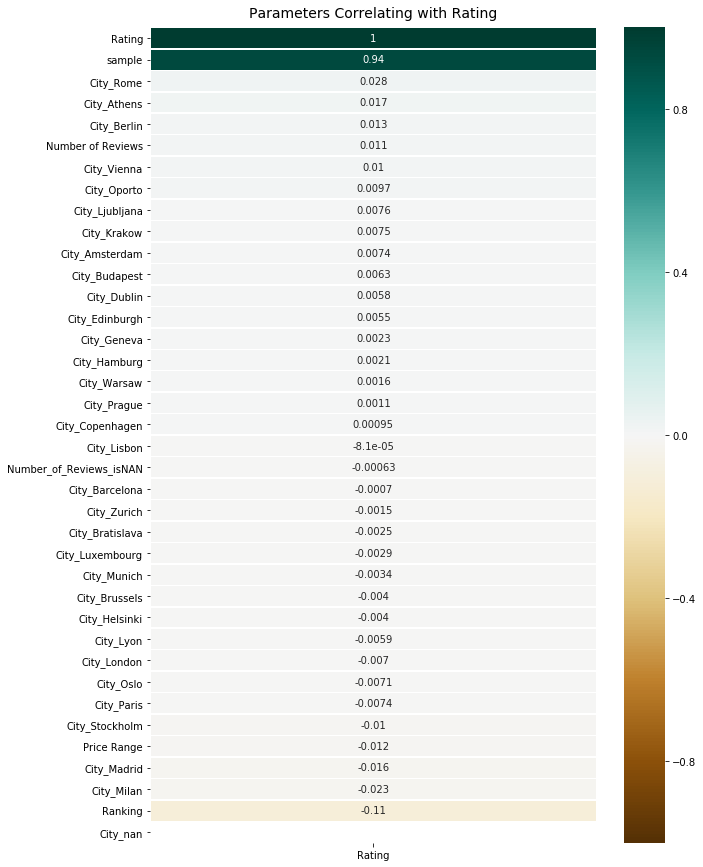

In [27]:
fig, ax = plt.subplots(figsize=(10,15))
heatmap = sns.heatmap(data.corr()[['Rating']].sort_values(by='Rating', ascending=False)
                      , vmin=-1, vmax=1, annot=True,linewidths=.5, ax=ax, cmap='BrBG')
heatmap.set_title('Parameters Correlating with Rating', fontdict={'fontsize':14}, pad=10);

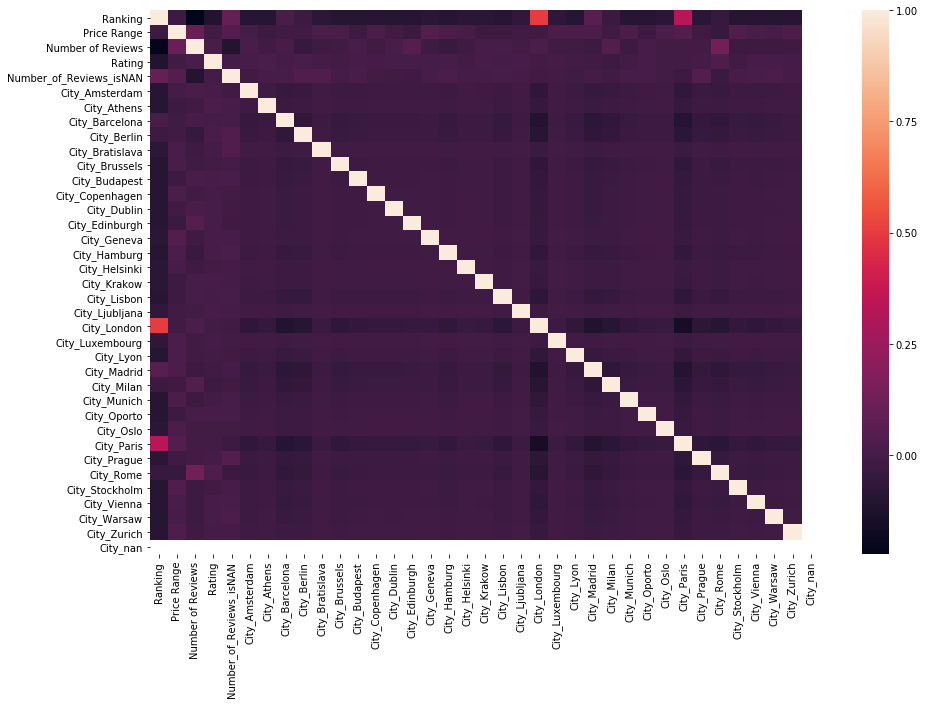

In [28]:
plt.rcParams['figure.figsize'] = (15,10)
sns.heatmap(data.drop(['sample'], axis=1).corr(),)

# Data Preprocessing
Теперь, для удобства и воспроизводимости кода, завернем всю обработку в одну большую функцию.

In [29]:
# на всякий случай, заново подгружаем данные
df_train = pd.read_csv(DATA_DIR+'/main_task.csv')
df_test = pd.read_csv(DATA_DIR+'/kaggle_task.csv')
df_train['sample'] = 1 # помечаем где у нас трейн
df_test['sample'] = 0 # помечаем где у нас тест
df_test['Rating'] = 0 # в тесте у нас нет значения Rating, мы его должны предсказать, по этому пока просто заполняем нулями

data = df_test.append(df_train, sort=False).reset_index(drop=True) # объединяем
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 11 columns):
Restaurant_id        50000 non-null object
City                 50000 non-null object
Cuisine Style        38410 non-null object
Ranking              50000 non-null float64
Price Range          32639 non-null object
Number of Reviews    46800 non-null float64
Reviews              49998 non-null object
URL_TA               50000 non-null object
ID_TA                50000 non-null object
sample               50000 non-null int64
Rating               50000 non-null float64
dtypes: float64(3), int64(1), object(7)
memory usage: 4.2+ MB


In [30]:
def preproc_data(df_input):
    '''includes several functions to pre-process the predictor data.'''
    
    df_output = df_input.copy()
    
    # ################### 1. Предобработка ############################################################## 
    # убираем не нужные для модели признаки
    df_output.drop(['Restaurant_id','ID_TA',], axis = 1, inplace=True)
    
    
    # ################### 2. NAN ############################################################## 
    # Далее заполняем пропуски, вы можете попробовать заполнением средним или средним по городу и тд...
    df_output['Number of Reviews'].fillna(0, inplace=True)
    # тут ваш код по обработке NAN
    # ....
    
    
    # ################### 3. Encoding ############################################################## 
    # для One-Hot Encoding в pandas есть готовая функция - get_dummies. Особенно радует параметр dummy_na
    df_output = pd.get_dummies(df_output, columns=[ 'City',], dummy_na=True)
    # тут ваш код не Encoding фитчей
    df_output['Price Range'] = df_output['Price Range'].apply(lambda x: str(x).replace('$$$$','3'))
    df_output['Price Range'] = df_output['Price Range'].apply(lambda x: str(x).replace('$$ - $$$','2'))
    df_output['Price Range'] = df_output['Price Range'].apply(lambda x: str(x).replace('$','1'))
    df_output['Price Range'] = df_output['Price Range'].apply(pd.to_numeric, downcast='integer', errors='coerce')
    df_output['Price Range'].fillna(df_output['Price Range'].median(), inplace=True)
    df_output['Price Range'] = df_output['Price Range'].astype(int)
    
    # ################### 4. Feature Engineering ####################################################
    # Признак Cuisine
    # Заполним пропуски значением местная кухня "local"
    df_output['Cuisine Style'].fillna('local', inplace=True)
    # Добавим столбец количество кухонь
    df_output['Cuisine Style'] = df_output['Cuisine Style'].apply(lambda x: str(x).replace('[',''))
    df_output['Cuisine Style'] = df_output['Cuisine Style'].apply(lambda x: str(x).replace(']',''))
    df_output['Cuisine Style'] = df_output['Cuisine Style'].apply(lambda x: str(x).replace(' ',''))
    df_output['Cuisine Style'] = df_output['Cuisine Style'].apply(lambda x:x.split(','))
    df_output['cuisine_number'] = df_output['Cuisine Style'].apply(lambda x: len(x))
    
    # Создадаим переменные для кухонь, которые встречаются в Датасете
    multilabel_encoded_results = multilabelbinarizer.fit_transform(df_output['Cuisine Style'])
    # Конвертируем Numpy Array в датафрейм pandas
    df_multilabel_data = pd.DataFrame(multilabel_encoded_results, columns=multilabelbinarizer.classes_)
    # Добавляем полученные классы к датафрейму
    df_output = pd.concat([df_output, df_multilabel_data], axis=1)
    
    
    # Признак Review
    # Находим даты в отзывах и выделяем их в отдельный столбик
    df_output['Reviews'].fillna('none', inplace=True)
    pattern = re.compile("\d+\/\d+\/\d+")
    df_output['review_date'] = df_output['Reviews'].apply(pattern.findall)
    df_output['review_date'] = df_output['review_date'].apply(lambda x: str(x).replace('[',''))
    df_output['review_date'] = df_output['review_date'].apply(lambda x: str(x).replace(']',''))
    df_output['review_date'] = df_output['review_date'].apply(lambda x:x.split(','))
    # Переводим данные в формат Datetime
    df_output['review_date'] = df_output['review_date'].apply(lambda x: [pd.to_datetime(i).date() for i in x])
    # Находим разницу между датой отзыва и сегодняшним днем и выносим эти данные в отдельный столбик
    def review_delta(row):
        if len(row['review_date'])==2:
            return abs((datetime.today().date() - row['review_date'][0]).days)
        return 0
    #Заполняем столбец с новым признаком
    df_output['review_delta']=df_output.apply(lambda row: review_delta(row), axis=1)
    
    
    
    
    # ################### 5. Clean #################################################### 
    # убираем признаки которые еще не успели обработать, 
    # модель на признаках с dtypes "object" обучаться не будет, просто выберим их и удалим
    object_columns = [s for s in df_output.columns if df_output[s].dtypes == 'object']
    df_output.drop(object_columns, axis = 1, inplace=True)
    
    return df_output

>По хорошему, можно было бы перевести эту большую функцию в класс и разбить на подфункции (согласно ООП). 

#### Запускаем и проверяем что получилось

In [31]:
df_preproc = preproc_data(data)
df_preproc.sample(10)

,Ranking,Price Range,Number of Reviews,sample,Rating,City_Amsterdam,City_Athens,City_Barcelona,City_Berlin,City_Bratislava,...,'VeganOptions','VegetarianFriendly','Venezuelan','Vietnamese','Welsh','WineBar','Xinjiang','Yunnan',local,review_delta
47584,5153.0,2,18.0,1,4.0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1892
30545,1247.0,1,25.0,1,4.0,0,0,0,0,0,...,1,1,0,0,0,0,0,0,0,1442
27513,874.0,2,5.0,1,4.5,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
25793,1230.0,1,28.0,1,4.5,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1374
45860,15389.0,2,64.0,1,3.0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1264
9902,2164.0,2,64.0,0,0.0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1378
5682,671.0,2,266.0,0,0.0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,1218
39755,3054.0,1,36.0,1,4.5,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1199
34225,2274.0,2,3.0,1,5.0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
8485,1184.0,2,12.0,0,0.0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1303


In [32]:
df_preproc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Columns: 165 entries, Ranking to review_delta
dtypes: float64(3), int64(130), uint8(32)
memory usage: 52.3 MB


In [33]:
# Теперь выделим тестовую часть
train_data = df_preproc.query('sample == 1').drop(['sample'], axis=1)
test_data = df_preproc.query('sample == 0').drop(['sample'], axis=1)

y = train_data.Rating.values            # наш таргет
X = train_data.drop(['Rating'], axis=1)

**Перед тем как отправлять наши данные на обучение, разделим данные на еще один тест и трейн, для валидации. 
Это поможет нам проверить, как хорошо наша модель работает, до отправки submissiona на kaggle.**

In [34]:
# Воспользуемся специальной функцие train_test_split для разбивки тестовых данных
# выделим 20% данных на валидацию (параметр test_size)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

In [35]:
# проверяем
test_data.shape, train_data.shape, X.shape, X_train.shape, X_test.shape

((10000, 164), (40000, 164), (40000, 163), (32000, 163), (8000, 163))

# Model 
Сам ML

In [36]:
# Импортируем необходимые библиотеки:
from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели
from sklearn import metrics # инструменты для оценки точности модели

In [37]:
# Создаём модель (НАСТРОЙКИ НЕ ТРОГАЕМ)
model = RandomForestRegressor(n_estimators=100, verbose=1, n_jobs=-1, random_state=RANDOM_SEED)

In [38]:
# Обучаем модель на тестовом наборе данных
model.fit(X_train, y_train)

# Используем обученную модель для предсказания рейтинга ресторанов в тестовой выборке.
# Предсказанные значения записываем в переменную y_pred
y_pred = model.predict(X_test)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    7.3s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   16.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


In [39]:
# Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они в среднем отличаются
# Метрика называется Mean Absolute Error (MAE) и показывает среднее отклонение предсказанных значений от фактических.
print('MAE:', metrics.mean_absolute_error(y_test, y_pred))

MAE: 0.20815999999999996


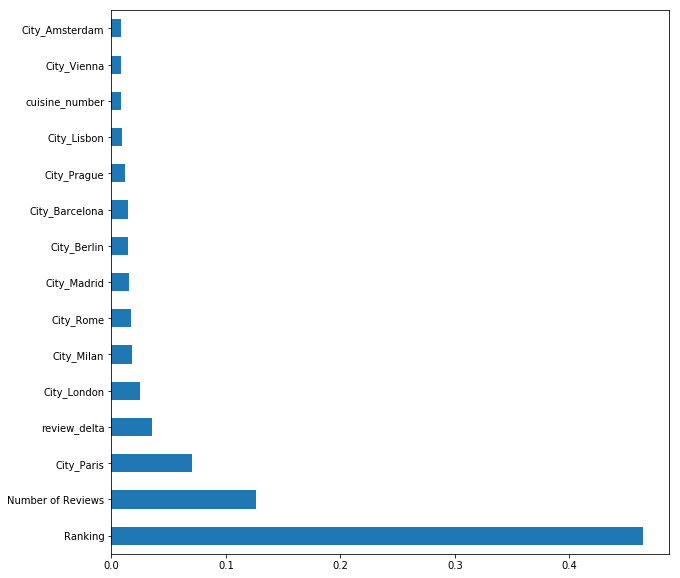

In [40]:
# в RandomForestRegressor есть возможность вывести самые важные признаки для модели
plt.rcParams['figure.figsize'] = (10,10)
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(15).plot(kind='barh')

# Submission
Если все устраевает - готовим Submission на кагл

In [41]:
test_data.sample(10)

,Ranking,Price Range,Number of Reviews,Rating,City_Amsterdam,City_Athens,City_Barcelona,City_Berlin,City_Bratislava,City_Brussels,...,'VeganOptions','VegetarianFriendly','Venezuelan','Vietnamese','Welsh','WineBar','Xinjiang','Yunnan',local,review_delta
4196,8542.0,2,3.0,0.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9703,1308.0,2,28.0,0.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1353
133,1561.0,2,200.0,0.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1210
6689,2552.0,1,42.0,0.0,0,0,0,0,0,0,...,1,1,0,0,0,0,0,0,0,1208
692,3961.0,2,127.0,0.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1227
7423,1501.0,2,9.0,0.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1633
4250,13278.0,2,9.0,0.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2959
7355,15921.0,2,4.0,0.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1748
180,789.0,2,540.0,0.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1282
76,10397.0,2,12.0,0.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,2787


In [42]:
test_data = test_data.drop(['Rating'], axis=1)

In [43]:
sample_submission

,Restaurant_id,Rating
0,id_0,2.0
1,id_1,2.5
2,id_2,4.0
3,id_3,1.0
4,id_4,4.0
...,...,...
9995,id_9995,3.0
9996,id_9996,1.5
9997,id_9997,4.5
9998,id_9998,1.0


In [44]:
predict_submission = model.predict(test_data)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


In [45]:
predict_submission

array([2.965, 4.165, 4.425, ..., 3.005, 4.495, 4.135])

In [46]:
sample_submission['Rating'] = predict_submission
sample_submission.to_csv('submission.csv', index=False)
sample_submission.head(10)

,Restaurant_id,Rating
0,id_0,2.965
1,id_1,4.165
2,id_2,4.425
3,id_3,4.345
4,id_4,4.465
5,id_5,4.485
6,id_6,1.915
7,id_7,2.570
8,id_8,3.875
9,id_9,4.570
